In [1]:
!pip install mido torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 18.5 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pickle
import math
from tqdm.auto import tqdm
from mido import Message, MidiFile, MidiTrack
import torchmetrics
from torch.utils.data import Dataset, DataLoader

/usr/local/lib/python3.12/dist-packages/torch_xla/experimental/gru.py:113: SyntaxWarning: invalid escape sequence '\_'
  * **h_n**: tensor of shape :math:`(D * \text{num\_layers}, H_{out})` or


In [3]:
!git clone https://github.com/czhuang/JSB-Chorales-dataset.git

Cloning into 'JSB-Chorales-dataset'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 46 (delta 4), reused 10 (delta 4), pack-reused 36 (from 1)
Receiving objects: 100% (46/46), 2.78 MiB | 12.54 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [4]:
with open('JSB-Chorales-dataset/jsb-chorales-16th.pkl', 'rb') as p:
    data = pickle.load(p, encoding="latin1")

In [5]:
n_embd = 128
n_head = 8
head_size = n_embd // n_head
block_size=4
dropout=0.2
MIN_VAL = 36
MAX_VAL = 81
VOCAB_SIZE = (MAX_VAL - MIN_VAL + 1) + 1
PAD_IDX = VOCAB_SIZE - 1
embed_dim=128

In [6]:
data.keys()

dict_keys(['test', 'train', 'valid'])

In [7]:
print(np.array(data['train'],dtype="object").shape)
print(np.array(data['test'],dtype="object").shape)
print(np.array(data['valid'],dtype="object").shape)

(229,)
(77,)
(76,)


In [8]:
train_data = data['train']
print(f"Type of train_data: {type(train_data)}")
print(f"Number of sequences in train_data: {len(train_data)}")
print(f"Type of the first sequence: {type(train_data[0])}")
print(f"Length of the first sequence: {len(train_data[0])}")
print(f"Type of the first element in the first sequence: {type(train_data[0][0])}")
print(f"Content of the first element in the first sequence:\n{train_data[0][0]}")

Type of train_data: <class 'list'>
Number of sequences in train_data: 229
Type of the first sequence: <class 'list'>
Length of the first sequence: 192
Type of the first element in the first sequence: <class 'tuple'>
Content of the first element in the first sequence:
(np.int64(74), np.int64(70), np.int64(65), np.int64(58))


In [9]:
train_dataset=data['train']
val_dataset=data['valid']
test_dataset=data['test']

train_loader=DataLoader(train_dataset,batch_size=128,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=128)
test_loader=DataLoader(test_dataset,batch_size=128)

In [10]:
class Head(nn.Module):
  def __init__(self, head_size):
    super().__init__()
    self.key = nn.Linear(n_embd, head_size, bias=False)
    self.query = nn.Linear(n_embd, head_size, bias=False)
    self.value = nn.Linear(n_embd, head_size, bias=False)
    self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
    self.dropout = nn.Dropout(dropout)

    # Learnable relative positional embeddings
    # The size should be enough to cover relative distances up to block_size
    # For relative bias, the maximum relative distance in a sequence of length T is T-1.
    # If we consider distances from -(T-1) to T-1, we need 2*T - 1 unique biases.
    # However, relative positional bias is typically based on the difference in indices (j-i).
    # For a sequence of length T, the relative positions j-i range from -(T-1) to T-1.
    # The number of unique relative positions is 2*T - 1.
    # A common approach for relative positional bias in self-attention is to have
    # biases for relative distances within a certain window size, often related to block_size.
    # Let's assume the relative bias is for distances up to block_size in both directions.
    # The relative distance between index i and j is j - i.
    # The range of j-i for i, j in [0, T-1] is -(T-1) to T-1.
    # We need biases for these relative distances.
    # A simpler form of relative bias is to have a bias tensor of shape (2*block_size - 1)
    # and map the relative distance (j-i) to an index in this tensor.

    # Let's redefine relative_bias to be for relative distances up to block_size
    # The relative distances (j-i) for 0 <= i, j < block_size range from -(block_size-1) to (block_size-1).
    # The number of unique relative distances is 2*block_size - 1.
    self.relative_bias = nn.Parameter(torch.randn(2 * block_size - 1))


  def forward(self, x):
    B, T, C = x.shape
    k = self.key(x)   # (B, T, head_size)
    q = self.query(x) # (B, T, head_size)
    v = self.value(x) # (B, T, head_size)

    # Compute attention scores ("affinities")
    # (B, T, head_size) @ (B, head_size, T) -> (B, T, T)
    wei = q @ k.transpose(-2, -1) * C**-0.5

    # Add relative positional bias
    # Calculate relative positions for the current sequence length T
    i = torch.arange(T).unsqueeze(1).to(x.device)
    j = torch.arange(T).unsqueeze(0).to(x.device)
    relative_positions = j - i # Shape (T, T)

    # Map relative positions to indices in self.relative_bias
    # The relative positions range from -(T-1) to T-1.
    # We need to map these to indices from 0 to 2*block_size - 2.
    # We can clip the relative positions to the range [-(block_size-1), block_size-1]
    # and then shift them to be non-negative indices.
    relative_positions_clipped = torch.clamp(relative_positions, min=-(block_size - 1), max=(block_size - 1))
    relative_bias_indices = relative_positions_clipped + (block_size - 1) # Shift to be non-negative

    # Lookup bias values using the indices
    # self.relative_bias has shape (2*block_size - 1)
    # relative_bias_indices has shape (T, T)
    # The lookup should result in a tensor of shape (T, T)
    relative_bias_to_add = self.relative_bias[relative_bias_indices] # Shape (T, T)

    # Add the relative bias to the attention scores
    wei = wei + relative_bias_to_add.unsqueeze(0) # Unsqueeze to broadcast across batch dimension (B, T, T) + (1, T, T)


    # Apply causal masking
    # The tril buffer was defined with block_size, need to adjust for current T
    tril_T = torch.tril(torch.ones(T, T, dtype=torch.bool, device=x.device))
    wei = wei.masked_fill(tril_T == 0, float('-inf')) # (B, T, T)


    # Apply softmax and dropout
    wei = F.softmax(wei, dim=-1) # (B, T, T)
    wei = self.dropout(wei)

    # Perform the weighted aggregation of the values
    out = wei @ v # (B, T, T) @ (B, T, head_size) -> (B, T, head_size)
    return out

In [11]:
class MultiHeadAttention(nn.Module):
  def __init__(self, num_heads=n_head, head_size=n_embd//n_head):
    super().__init__()
    self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
    self.proj = nn.Linear(n_embd, n_embd)
    self.dropout = nn.Dropout(dropout) # Add dropout layer

  def forward(self, x):
    out = torch.cat([h(x) for h in self.heads], dim=-1)
    out = self.proj(out)
    out = self.dropout(out)
    return out

In [12]:
class TransformerBlock(nn.Module):
    def __init__(self, n_embd, n_head, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadAttention(n_head, head_size)
        self.norm1 = nn.LayerNorm(n_embd)
        self.norm2 = nn.LayerNorm(n_embd)

        self.ffwd = nn.Sequential(
            nn.Linear(n_embd, n_embd * 4),  # expand (feed-forward inner layer)
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(n_embd * 4, n_embd),  # project back
            nn.Dropout(dropout),
        )

    def forward(self, input_tensor): # Renamed input variable
        # Pre-LN Attention
        # print(f"Shape before norm1 in TransformerBlock: {input_tensor.shape}") # Use input_tensor
        x = input_tensor + self.attn(self.norm1(input_tensor)) # Use input_tensor for norm1
        # print(f"Shape after attention in TransformerBlock: {x.shape}") # Add print statement

        # Pre-LN Feed Forward
        # print(f"Shape before norm2 in TransformerBlock: {x.shape}") # x is the output of attention
        x = x + self.ffwd(self.norm2(x))
        # print(f"Shape after ffwd in TransformerBlock: {x.shape}") # Add print statement

        return x

In [13]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        vocab_size = 82
        self.embedding = nn.Embedding(vocab_size, n_embd)
        self.transformer_blocks = nn.ModuleList([TransformerBlock(n_embd, n_head) for _ in range(8)])
        self.linear = nn.Linear(n_embd, vocab_size)

    def forward(self, x):
        # x shape: (batch_size, seq_len)
        batch_size, seq_len = x.shape

        # Embedding
        x = self.embedding(x)  # (batch_size, seq_len, n_embd)

        # Transformer
        for block in self.transformer_blocks:
            x = block(x)

        # Output logits
        logits = self.linear(x)  # (batch_size, seq_len, vocab_size)

        return logits

In [14]:
model=Model()

In [15]:
# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Using Adam optimizer with a learning rate of 0.001

# Define the loss function
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX) # Using Cross-Entropy Loss, suitable for classification tasks like this

In [16]:
def __getitem__(self, idx):
    seq = self.data[idx]

    # Ensure each event has exactly 4 elements
    fixed_seq = []
    for event in seq:
        if len(event) == 4:
            fixed_seq.append(event)
        elif len(event) > 4:   # truncate
            fixed_seq.append(event[:4])
        elif len(event) < 4:   # pad inside event
            fixed_seq.append(event + [PAD_IDX] * (4 - len(event)))

    return torch.tensor(fixed_seq, dtype=torch.long)


In [17]:
# Adjust your sequences when you create them
def encode_sequence(seq):
    # shift values so they start at 0
    return [x - MIN_VAL for x in seq]

def pad_collate(batch, pad_idx: int = PAD_IDX):
    """
    Collate function that:
      - drops empty/malformed samples
      - always returns a tensor (never None)
      - pads to the max seq len in the (cleaned) batch with pad_idx
      - flattens inputs that come in with extra dims
    Output shape: [batch_size, max_seq_len]
    """
    cleaned = []

    for j, seq in enumerate(batch):
        if seq is None:
            continue
        try:
            t = torch.as_tensor(seq, dtype=torch.long)
            if t.numel() == 0:
                continue
            if t.dim() > 1:
                # flatten if something arrives as 2D/ND
                t = t.view(-1)
            cleaned.append(t)
        except Exception:
            # skip malformed sample silently (or log if you prefer)
            # print(f"Skipping sample {j}: {e}")
            continue

    if not cleaned:
        # Return a tiny dummy batch so DataLoader never yields None.
        # Two PAD tokens ensure src=inputs[:, :-1] and targets=inputs[:, 1:]
        # both have valid shapes; loss will ignore PAD via ignore_index.
        return torch.full((1, 2), pad_idx, dtype=torch.long)

    # Pad to max length in this batch
    max_len = max(t.size(0) for t in cleaned)
    out = torch.full((len(cleaned), max_len), pad_idx, dtype=torch.long)
    for i, t in enumerate(cleaned):
        out[i, :t.size(0)] = t

    return out


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=pad_collate)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False, collate_fn=pad_collate)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, collate_fn=pad_collate)


# Model Embedding
embedding = nn.Embedding(VOCAB_SIZE, embed_dim, padding_idx=PAD_IDX)


In [18]:
def train(model, train_loader, optimizer, criterion, pad_idx):
    model.train()
    running_loss = 0.0
    total_batches = 0

    chunk_size = 256  # or 128, depending on memory

    for i, inputs in enumerate(tqdm(train_loader, desc="Training")):
        if inputs is None:
            continue

        # Split sequences into chunks
        batch_chunks = inputs.unfold(1, chunk_size, chunk_size)  # (batch_size, num_chunks, chunk_size)
        batch_size, num_chunks, seq_len = batch_chunks.shape

        # Flatten batch and chunks
        batch_chunks = batch_chunks.contiguous().view(batch_size * num_chunks, seq_len)

        # Create inputs and targets
        src = batch_chunks[:, :-1]
        targets = batch_chunks[:, 1:]

        # Print batch info every 5 batches
        if i % 5 == 0:
            print(f"[Batch {i}] src shape: {src.shape}, targets shape: {targets.shape}")
            print(f"First src row: {src[0]}")
            print(f"First targets row: {targets[0]}")

        # Forward pass
        outputs = model(src)  # (batch_size*num_chunks, seq_len-1, vocab_size)

        # Print logits stats
        if i % 5 == 0:
            print(f"Logits min/max/mean: {outputs.min().item():.3f}/{outputs.max().item():.3f}/{outputs.mean().item():.3f}")

        # Reshape for loss
        batch_size_total, seq_len_total, vocab_size = outputs.shape
        outputs_for_loss = outputs.contiguous().view(-1, vocab_size)
        targets_for_loss = targets.contiguous().view(-1)

        # Compute loss
        loss = criterion(outputs_for_loss, targets_for_loss)

        # Print batch loss
        if i % 5 == 0:
            print(f"Batch {i} loss: {loss.item():.4f}")

        # Backprop + optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        total_batches += 1

    epoch_loss = running_loss / total_batches if total_batches > 0 else float('inf')
    print(f'Finished Training. Epoch Loss: {epoch_loss:.3f}')
    return epoch_loss


In [19]:
def evaluate(model, data_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0

    # Initialize accuracy metric
    accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=82)  # Assuming vocab_size is 82

    with torch.no_grad():  # Disable gradient calculation
        for inputs in tqdm(data_loader, desc="Evaluating"):
            if inputs is None:  # skip empty batches if using your pad_collate
                continue

            # Prepare input and target sequences
            src = inputs[:, :-1]      # model input
            targets = inputs[:, 1:]   # shifted by one, no extra dimension

            # Forward pass
            outputs = model(src)      # (batch_size, seq_len-1, vocab_size)

            # Reshape for loss
            batch_size, seq_len, vocab_size = outputs.shape
            outputs_for_loss = outputs.contiguous().view(-1, vocab_size)
            targets_for_loss = targets.contiguous().view(-1)

            # Calculate loss
            loss = criterion(outputs_for_loss, targets_for_loss)
            total_loss += loss.item() * src.size(0)  # weighted by batch size

            # Accuracy
            predicted_tokens = torch.argmax(outputs_for_loss, dim=-1)
            accuracy_metric.update(predicted_tokens.cpu(), targets_for_loss.cpu())

    average_loss = total_loss / len(data_loader.dataset)
    perplexity = torch.exp(torch.tensor(average_loss))
    accuracy = accuracy_metric.compute()

    print(f'Evaluation Loss: {average_loss:.3f}, Perplexity: {perplexity:.3f}, Accuracy: {accuracy:.3f}')
    return average_loss, perplexity, accuracy


Starting training for 7 epochs...

Epoch 1/7


Training:   0%|          | 0/8 [00:00<?, ?it/s]

[Batch 0] src shape: torch.Size([168, 255]), targets shape: torch.Size([168, 255])
First src row: tensor([74, 67, 58, 55, 74, 67, 58, 55, 74, 67, 58, 55, 74, 67, 58, 55, 75, 67,
        58, 48, 75, 67, 58, 48, 75, 67, 58, 48, 75, 67, 58, 48, 74, 65, 57, 53,
        74, 65, 57, 53, 72, 65, 57, 53, 72, 65, 57, 53, 74, 65, 58, 46, 74, 65,
        58, 46, 74, 65, 58, 46, 74, 65, 58, 46, 67, 64, 60, 58, 67, 64, 60, 58,
        67, 64, 62, 58, 67, 64, 62, 58, 72, 66, 63, 57, 72, 66, 63, 57, 72, 67,
        63, 55, 72, 67, 63, 55, 72, 69, 62, 54, 72, 69, 62, 54, 72, 69, 62, 54,
        72, 69, 62, 54, 70, 67, 62, 55, 70, 67, 62, 55, 69, 66, 60, 55, 69, 66,
        60, 55, 70, 67, 62, 48, 70, 67, 62, 48, 72, 69, 63, 48, 72, 69, 63, 48,
        69, 66, 62, 50, 69, 66, 62, 50, 69, 66, 62, 50, 69, 66, 62, 50, 69, 66,
        60, 50, 69, 66, 60, 50, 69, 66, 60, 50, 69, 66, 60, 50, 67, 62, 58, 43,
        67, 62, 58, 43, 67, 62, 58, 43, 67, 62, 58, 43, 74, 67, 58, 55, 74, 67,
        58, 55, 74, 67

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation Loss: 2.312, Perplexity: 10.097, Accuracy: 0.110
Epoch 1 - Val Loss: 2.312, Val Perplexity: 10.097, Val Accuracy: 0.110

Epoch 2/7


Training:   0%|          | 0/8 [00:00<?, ?it/s]

[Batch 0] src shape: torch.Size([192, 255]), targets shape: torch.Size([192, 255])
First src row: tensor([71, 67, 64, 52, 71, 67, 64, 52, 71, 67, 64, 52, 71, 67, 64, 52, 71, 66,
        59, 50, 71, 66, 59, 50, 71, 66, 59, 50, 71, 66, 59, 50, 69, 64, 60, 48,
        69, 64, 60, 48, 69, 63, 54, 48, 69, 63, 54, 48, 67, 64, 55, 48, 67, 64,
        55, 48, 67, 64, 55, 47, 67, 64, 55, 47, 66, 64, 60, 45, 66, 64, 60, 45,
        66, 64, 60, 45, 66, 64, 60, 45, 66, 63, 59, 47, 66, 63, 59, 47, 66, 63,
        57, 47, 66, 63, 57, 47, 64, 59, 55, 52, 64, 59, 55, 52, 64, 59, 55, 52,
        64, 59, 55, 52, 64, 59, 55, 52, 64, 59, 55, 52, 64, 59, 55, 52, 64, 59,
        55, 52, 71, 67, 64, 52, 71, 67, 64, 52, 71, 66, 62, 52, 71, 66, 62, 52,
        73, 64, 61, 57, 73, 64, 61, 57, 73, 64, 59, 55, 73, 64, 59, 55, 74, 62,
        57, 54, 74, 62, 57, 54, 74, 62, 57, 54, 74, 62, 57, 54, 71, 62, 55, 55,
        71, 62, 55, 55, 71, 62, 57, 54, 71, 62, 57, 54, 76, 67, 59, 52, 76, 67,
        59, 52, 76, 69

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation Loss: 2.077, Perplexity: 7.978, Accuracy: 0.127
Epoch 2 - Val Loss: 2.077, Val Perplexity: 7.978, Val Accuracy: 0.127

Epoch 3/7


Training:   0%|          | 0/8 [00:00<?, ?it/s]

[Batch 0] src shape: torch.Size([217, 255]), targets shape: torch.Size([217, 255])
First src row: tensor([62, 57, 54, 50, 62, 57, 54, 50, 64, 57, 55, 50, 64, 57, 55, 50, 66, 62,
        57, 50, 66, 62, 57, 50, 66, 62, 57, 49, 66, 62, 57, 49, 67, 62, 55, 47,
        67, 62, 55, 47, 67, 62, 54, 47, 67, 62, 54, 47, 69, 64, 52, 49, 69, 64,
        52, 49, 69, 64, 52, 49, 69, 64, 52, 49, 69, 62, 54, 50, 69, 62, 54, 50,
        69, 61, 54, 50, 69, 61, 54, 50, 67, 59, 55, 52, 67, 59, 55, 52, 67, 61,
        55, 52, 67, 61, 55, 52, 66, 62, 57, 54, 66, 62, 57, 54, 66, 62, 57, 55,
        66, 62, 57, 55, 64, 61, 57, 57, 64, 61, 57, 57, 64, 61, 57, 57, 64, 61,
        57, 57, 69, 64, 57, 61, 69, 64, 57, 61, 69, 64, 57, 61, 69, 64, 57, 61,
        71, 66, 62, 59, 71, 66, 62, 59, 71, 68, 62, 59, 71, 68, 62, 59, 73, 69,
        64, 57, 73, 69, 64, 57, 73, 69, 64, 57, 73, 69, 64, 57, 74, 71, 64, 56,
        74, 71, 64, 56, 74, 71, 64, 56, 74, 71, 64, 56, 73, 69, 64, 57, 73, 69,
        64, 57, 73, 69

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation Loss: 1.967, Perplexity: 7.151, Accuracy: 0.140
Epoch 3 - Val Loss: 1.967, Val Perplexity: 7.151, Val Accuracy: 0.140

Epoch 4/7


Training:   0%|          | 0/8 [00:00<?, ?it/s]

[Batch 0] src shape: torch.Size([186, 255]), targets shape: torch.Size([186, 255])
First src row: tensor([66, 62, 59, 59, 66, 62, 59, 59, 68, 64, 59, 59, 68, 64, 59, 59, 69, 66,
        61, 54, 69, 66, 61, 54, 69, 66, 61, 54, 69, 66, 61, 54, 71, 68, 62, 53,
        71, 68, 62, 53, 71, 68, 62, 53, 71, 68, 62, 53, 69, 66, 61, 54, 69, 66,
        61, 54, 69, 66, 61, 54, 69, 66, 61, 54, 74, 66, 59, 59, 74, 66, 59, 59,
        74, 66, 59, 59, 74, 66, 59, 59, 74, 64, 59, 56, 74, 64, 59, 56, 74, 64,
        59, 56, 74, 64, 59, 56, 73, 64, 57, 57, 73, 64, 57, 57, 73, 64, 57, 57,
        73, 64, 57, 57, 74, 66, 57, 50, 74, 66, 57, 50, 74, 66, 57, 50, 74, 66,
        57, 50, 74, 66, 59, 47, 74, 66, 59, 47, 74, 68, 59, 47, 74, 68, 59, 47,
        73, 69, 64, 45, 73, 69, 64, 45, 73, 67, 64, 45, 73, 67, 64, 45, 71, 66,
        63, 57, 71, 66, 63, 57, 71, 66, 61, 57, 71, 66, 61, 57, 76, 67, 59, 55,
        76, 67, 59, 55, 76, 67, 59, 54, 76, 67, 59, 52, 76, 66, 59, 59, 76, 66,
        59, 59, 74, 66

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation Loss: 1.929, Perplexity: 6.881, Accuracy: 0.144
Epoch 4 - Val Loss: 1.929, Val Perplexity: 6.881, Val Accuracy: 0.144

Epoch 5/7


Training:   0%|          | 0/8 [00:00<?, ?it/s]

[Batch 0] src shape: torch.Size([186, 255]), targets shape: torch.Size([186, 255])
First src row: tensor([66, 62, 59, 59, 66, 62, 59, 59, 67, 62, 59, 59, 67, 62, 59, 59, 69, 62,
        57, 54, 69, 62, 57, 54, 69, 62, 57, 54, 69, 62, 57, 54, 71, 62, 55, 55,
        71, 62, 55, 55, 71, 62, 55, 55, 71, 62, 55, 55, 69, 62, 54, 50, 69, 62,
        54, 50, 69, 62, 55, 52, 69, 62, 55, 52, 74, 62, 57, 54, 74, 62, 57, 54,
        74, 64, 59, 55, 74, 64, 59, 55, 74, 66, 57, 57, 74, 66, 57, 57, 74, 67,
        57, 57, 74, 67, 57, 57, 73, 69, 64, 45, 73, 69, 64, 45, 73, 69, 64, 45,
        73, 69, 64, 45, 74, 69, 66, 50, 74, 69, 66, 50, 74, 69, 66, 50, 74, 69,
        66, 50, 74, 68, 64, 47, 74, 68, 64, 47, 74, 68, 62, 47, 74, 68, 62, 47,
        73, 69, 64, 45, 73, 69, 64, 45, 73, 69, 66, 45, 73, 69, 66, 45, 71, 67,
        67, 52, 71, 67, 67, 52, 71, 69, 67, 54, 71, 69, 67, 54, 76, 71, 67, 55,
        76, 71, 67, 55, 76, 71, 67, 57, 76, 71, 67, 57, 74, 71, 66, 59, 74, 71,
        66, 59, 73, 71

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation Loss: 1.897, Perplexity: 6.669, Accuracy: 0.148
Epoch 5 - Val Loss: 1.897, Val Perplexity: 6.669, Val Accuracy: 0.148

Epoch 6/7


Training:   0%|          | 0/8 [00:00<?, ?it/s]

[Batch 0] src shape: torch.Size([180, 255]), targets shape: torch.Size([180, 255])
First src row: tensor([69, 64, 60, 45, 69, 64, 60, 45, 69, 64, 60, 45, 69, 64, 60, 45, 69, 64,
        60, 57, 69, 64, 60, 57, 69, 64, 60, 57, 69, 64, 60, 57, 71, 64, 59, 56,
        71, 64, 59, 56, 71, 64, 59, 56, 71, 64, 59, 56, 72, 64, 57, 57, 72, 64,
        57, 57, 72, 64, 57, 57, 72, 64, 57, 57, 74, 62, 57, 54, 74, 62, 57, 54,
        74, 62, 57, 54, 74, 62, 57, 54, 71, 62, 55, 55, 71, 62, 55, 55, 71, 62,
        54, 55, 71, 62, 54, 55, 71, 67, 55, 55, 71, 67, 55, 55, 72, 66, 57, 55,
        72, 66, 57, 55, 74, 67, 59, 43, 74, 67, 59, 43, 74, 67, 59, 43, 74, 67,
        59, 43, 76, 64, 59, 56, 76, 64, 59, 56, 76, 64, 59, 56, 76, 64, 59, 56,
        72, 64, 57, 57, 72, 64, 57, 57, 72, 64, 59, 55, 72, 64, 59, 55, 69, 69,
        60, 53, 69, 69, 60, 53, 69, 69, 60, 52, 69, 69, 60, 52, 71, 69, 65, 50,
        71, 69, 65, 50, 71, 69, 65, 50, 71, 69, 65, 50, 71, 68, 64, 52, 71, 68,
        64, 52, 71, 68

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation Loss: 1.869, Perplexity: 6.480, Accuracy: 0.149
Epoch 6 - Val Loss: 1.869, Val Perplexity: 6.480, Val Accuracy: 0.149

Epoch 7/7


Training:   0%|          | 0/8 [00:00<?, ?it/s]

[Batch 0] src shape: torch.Size([217, 255]), targets shape: torch.Size([217, 255])
First src row: tensor([74, 65, 57, 50, 74, 65, 57, 50, 74, 67, 57, 52, 74, 67, 57, 52, 69, 69,
        62, 53, 69, 69, 62, 53, 69, 69, 62, 55, 69, 69, 62, 55, 72, 64, 60, 57,
        72, 64, 60, 57, 72, 64, 58, 55, 72, 64, 58, 55, 74, 65, 57, 53, 74, 65,
        57, 53, 76, 67, 57, 52, 76, 67, 57, 52, 77, 69, 62, 50, 77, 69, 62, 50,
        77, 69, 62, 50, 77, 69, 62, 50, 76, 69, 62, 57, 76, 69, 62, 57, 76, 69,
        60, 57, 76, 67, 60, 57, 74, 65, 60, 58, 74, 65, 60, 58, 74, 65, 58, 58,
        74, 65, 58, 58, 72, 65, 58, 53, 72, 65, 58, 53, 72, 65, 57, 53, 72, 65,
        57, 53, 70, 64, 57, 53, 70, 64, 57, 53, 70, 58, 55, 53, 70, 58, 55, 53,
        70, 60, 53, 48, 70, 60, 53, 48, 70, 60, 52, 48, 70, 60, 52, 48, 69, 60,
        53, 53, 69, 60, 53, 53, 69, 60, 53, 53, 69, 60, 53, 53, 69, 60, 53, 53,
        69, 60, 53, 53, 69, 60, 53, 53, 69, 60, 53, 53, 77, 65, 60, 57, 77, 65,
        60, 57, 77, 65

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation Loss: 1.835, Perplexity: 6.267, Accuracy: 0.156
Epoch 7 - Val Loss: 1.835, Val Perplexity: 6.267, Val Accuracy: 0.156

Training finished.


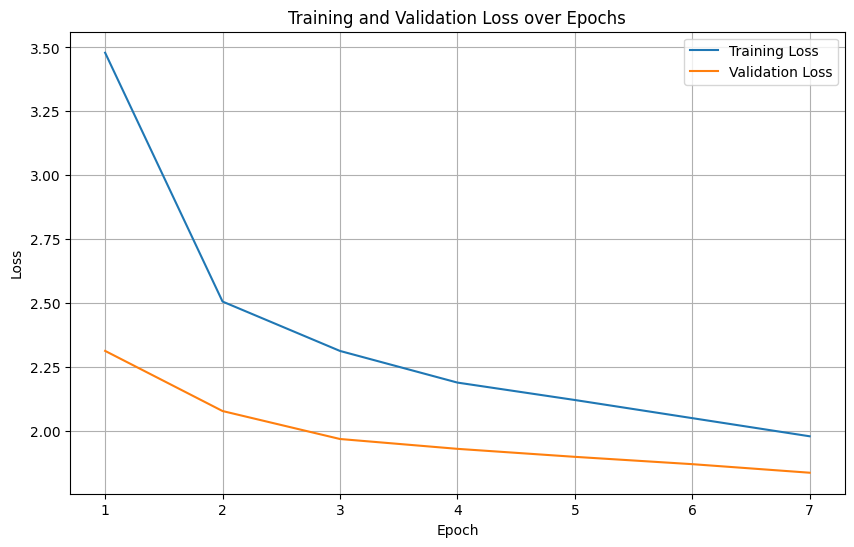

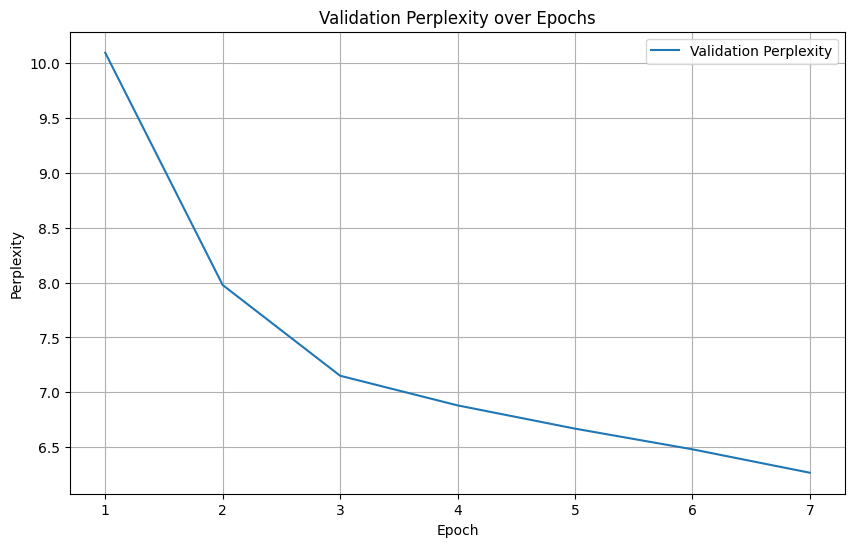

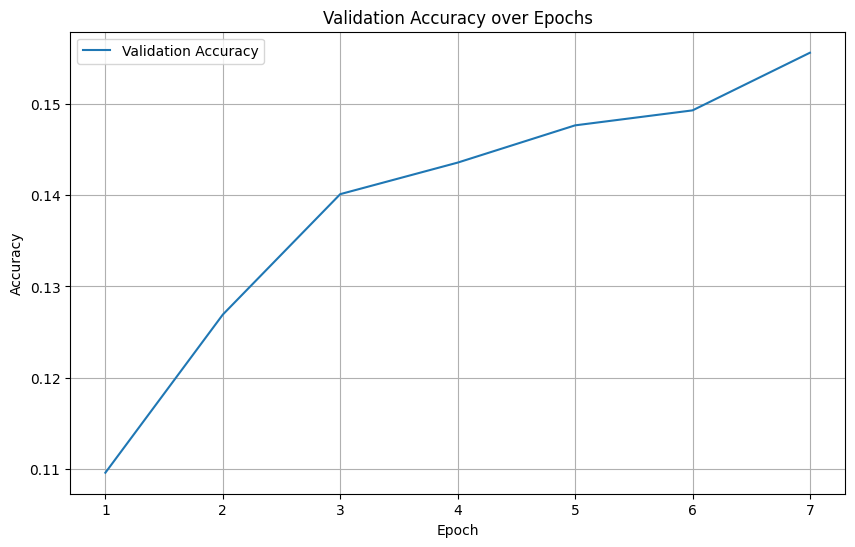

In [20]:
# Lists to store losses
train_losses = []
val_losses = []
val_perplexities = []
val_accuracies = []

num_epochs = 7 # Define the number of epochs

print(f"Starting training for {num_epochs} epochs...")

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Train for one epoch
    epoch_train_loss = train(model, train_loader, optimizer, criterion,PAD_IDX)
    train_losses.append(epoch_train_loss)

    # Evaluate on the validation set
    print(f"Evaluating after Epoch {epoch+1}...")
    epoch_val_loss, epoch_val_perplexity, epoch_val_accuracy = evaluate(model, val_loader, criterion)
    val_losses.append(epoch_val_loss)
    val_perplexities.append(epoch_val_perplexity.item()) # .item() to get scalar value
    val_accuracies.append(epoch_val_accuracy.item()) # .item() to get scalar value

    # Optional: Print validation metrics
    print(f"Epoch {epoch+1} - Val Loss: {epoch_val_loss:.3f}, Val Perplexity: {epoch_val_perplexity:.3f}, Val Accuracy: {epoch_val_accuracy:.3f}")


print("\nTraining finished.")

# Plotting the loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Optional: Plotting perplexity and accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), val_perplexities, label='Validation Perplexity')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Validation Perplexity over Epochs')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
# Define the path to save the model
model_save_path = 'final_model.pth'

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

print(f"Model saved successfully to {model_save_path}")

Model saved successfully to final_model.pth


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model().to(device)
model.load_state_dict(torch.load("final_model.pth", map_location=device))
model.eval()

VOCAB_SIZE = 82        # adjust if your vocab size is different
PITCH_OFFSET = 36      # lowest pitch in your dataset

idx_to_pitch = {i: i + PITCH_OFFSET for i in range(VOCAB_SIZE)}
pitch_to_idx = {v: k for k, v in idx_to_pitch.items()}
def generate(model, start_tokens, max_new_tokens=200, temperature=1.0, top_k=5):
    model.eval()
    generated = [pitch_to_idx[p] for p in start_tokens]  # convert seed pitches → indices

    for _ in range(max_new_tokens):
        current_seq_len = len(generated)

        # Build padded input (seq_len) with batch dimension (1)
        # Take the last `block_size` tokens for generation if the sequence is longer
        input_sequence = generated[-block_size:] if current_seq_len > block_size else generated[:]
        x = torch.tensor(input_sequence, dtype=torch.long).unsqueeze(0).to(device) # (1, min(current_seq_len, block_size))


        with torch.no_grad():
            logits = model(x)[:, -1, :]  # (1, vocab_size)

        # Temperature scaling
        logits = logits / temperature

        # Top-k filtering
        if top_k is not None:
            k = min(top_k, logits.size(-1))
            values, indices = torch.topk(logits, k)
            mask = torch.full_like(logits, float("-inf"))
            mask.scatter_(1, indices, values)
            logits = mask

        # Sample next token
        probs = F.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1).item()
        print("Step:", _, "logits max:", logits.max().item(), "next token:", next_token)

        generated.append(next_token)

    print("Generated indices:", generated[:50])
    print("Generated pitches:", [idx_to_pitch[i] for i in generated[:50]])
    # Convert indices → MIDI pitches
    return [idx_to_pitch[idx] for idx in generated]

# ----------------------------
# Convert to MIDI
# ----------------------------
def tokens_to_midi(tokens, out_file="generated.mid"):
    mid = MidiFile()
    track = MidiTrack()
    mid.tracks.append(track)

    duration = 240  # ticks per note (adjust tempo if needed)

    for pitch in tokens:
        if 0 <= pitch <= 127:  # valid MIDI pitch
            track.append(Message('note_on', note=pitch, velocity=64, time=0))
            track.append(Message('note_off', note=pitch, velocity=64, time=duration))

    mid.save(out_file)
    print(f"Saved MIDI: {out_file}")

# ----------------------------
# Run generation
# ----------------------------
start_pitches = [60, 64, 67]  # C4, E4, G4
generated_pitches = generate(model, start_pitches, max_new_tokens=200, temperature=0.8, top_k=10)
tokens_to_midi(generated_pitches, "bach_style3.mid")

Step: 0 logits max: 4.020343780517578 next token: 59
Step: 1 logits max: 7.353702068328857 next token: 56
Step: 2 logits max: 5.5467753410339355 next token: 52
Step: 3 logits max: 7.473395824432373 next token: 68
Step: 4 logits max: 8.313387870788574 next token: 64
Step: 5 logits max: 8.682016372680664 next token: 52
Step: 6 logits max: 6.876126289367676 next token: 68
Step: 7 logits max: 8.723294258117676 next token: 65
Step: 8 logits max: 6.327409744262695 next token: 62
Step: 9 logits max: 5.988369464874268 next token: 55
Step: 10 logits max: 5.836780071258545 next token: 71
Step: 11 logits max: 10.366154670715332 next token: 62
Step: 12 logits max: 9.057311058044434 next token: 55
Step: 13 logits max: 7.400458812713623 next token: 71
Step: 14 logits max: 9.669766426086426 next token: 67
Step: 15 logits max: 9.614582061767578 next token: 62
Step: 16 logits max: 8.880802154541016 next token: 55
Step: 17 logits max: 8.630721092224121 next token: 67
Step: 18 logits max: 10.691251754760